# Laboratorio 2 - Data Science

In [9]:
!pip install --upgrade pip
!pip install --upgrade numpy tensorflow
!pip install numpy==1.23.5

  Using cached numpy-2.3.2-cp311-cp311-win_amd64.whl.metadata (60 kB)
   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
    --------------------------------------- 0.3/14.6 MB ? eta -:--:--
    --------------------------------------- 0.3/14.6 MB ? eta -:--:--
    --------------------------------------- 0.3/14.6 MB ? eta -:--:--
    ----------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
scipy 1.16.0 requires numpy<2.6,>=1.25.2, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.


In [2]:
import numpy as np
import tensorflow as tf

(X_entreno, y_entreno), (X_prueba, y_prueba) = tf.keras.datasets.mnist.load_data()
X_entreno.shape

C:\Users\JM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\keras\engine\training_arrays_v1.py:37: UserWarning: A NumPy version >=1.25.2 and <2.6.0 is required for this version of SciPy (detected version 1.23.5)
  from scipy.sparse import issparse  # pylint: disable=g-import-not-at-top


(60000, 28, 28)

In [3]:
assert X_entreno.shape == (60000, 28, 28)
assert X_prueba.shape == (10000, 28, 28)
assert y_entreno.shape == (60000,)
assert y_prueba.shape == (10000,)

In [4]:
num_obs_validacion = y_prueba.shape[0]
num_obs_prueba = y_prueba.shape[0]


In [5]:
X_entreno_normalizado = X_entreno / 255
X_prueba_normalizado = X_prueba / 255

In [6]:
X_validacion = X_entreno_normalizado[-num_obs_validacion: , : , : ]
y_validacion = y_entreno[-num_obs_validacion:]

In [7]:
X_entreno = X_entreno_normalizado[ : X_entreno_normalizado.shape[0] - num_obs_validacion, : , : ]
y_entreno = y_entreno[ : y_entreno.shape[0] - num_obs_validacion]
num_obs_entreno = y_entreno.shape[0]

In [8]:
BATCH_SIZE = 100
datos_entreno = tf.data.Dataset.from_tensor_slices((X_entreno, y_entreno))
datos_validacion = tf.data.Dataset.from_tensor_slices((X_validacion, y_validacion))
datos_prueba = tf.data.Dataset.from_tensor_slices((X_prueba, y_prueba))

datos_entreno = datos_entreno.shuffle(buffer_size = num_obs_entreno).batch(BATCH_SIZE)
datos_validacion = datos_validacion.batch(BATCH_SIZE)
datos_prueba = datos_prueba.batch(BATCH_SIZE)


## Modelo

In [17]:
# Vars constantes
from matplotlib import pyplot as plt
import time
NUM_EPOCHS = 20

class RNN():
    def __init__(
            self,
            entrada,
            salida,
            capa_escondida,
        ):
        self.entrada = entrada
        self.salida = salida
        self.capa_escondida = capa_escondida
        
        self.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
            
            tf.keras.layers.Dense(capa_escondida, activation='relu'), # 2nda capa escondida

            tf.keras.layers.Dense(salida, activation='softmax') # capa salida
        ])
        self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
    def train(self, train_data, validation_data, num_epochs, verbose=0):
        start_time = time.time()
        self.history = self.model.fit(
            train_data,
            epochs = num_epochs, 
            validation_data = validation_data,
            verbose = verbose
        )
        end_time = time.time()
        train_loss = self.history.history['loss'][-1]
        train_acc = self.history.history['accuracy'][-1]
        val_loss = self.history.history['val_loss'][-1]
        val_acc = self.history.history['val_accuracy'][-1]
        t_time = end_time - start_time
        return (train_loss, train_acc, val_loss, val_acc, t_time)
    
    def test(self, test_data):
        loss, accuracy = self.model.evaluate(test_data)
        return (loss, accuracy)
    
    def plot_accuracy(self, title):
        plt.plot(self.history.history['accuracy'], label="Train")
        plt.plot(self.history.history['val_accuracy'], label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    def plot_loss(self, title):
        plt.plot(self.history.history['loss'], label="Train")
        plt.plot(self.history.history['val_loss'], label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        plt.show()

## 1. Modular Neuronas de capas internas

In [59]:
# iterar por cada una de las topologias
performance_1 = [] # almacenamiento de resultados

for inner_size in [50, 100, 200, 300, 500]:
    # Inicializar RNN
    m1 = RNN(784, 10, inner_size)
    # Compilar otpimizador
    m1.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Metricas de etrenamiento
    (e_loss, e_acc, _, _, t_time) = m1.train(datos_entreno, datos_validacion, num_epochs=20)
    # Metricas de prueba
    t_loss, t_acc = m1.test(datos_prueba)
    performance_1.append({"Ancho": inner_size, "e_loss": e_loss, "e_acc": e_acc, "t_loss": t_loss, "t_acc": t_acc, "training_time": t_time})
    print(f"finished for inner size {inner_size}")
    

C:\Users\JM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9714 - loss: 19.2333   
finished for inner size 50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9755 - loss: 20.2850
finished for inner size 100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9792 - loss: 18.0024
finished for inner size 200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9803 - loss: 17.7231  
finished for inner size 300
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9812 - loss: 17.6131
finished for inner size 500


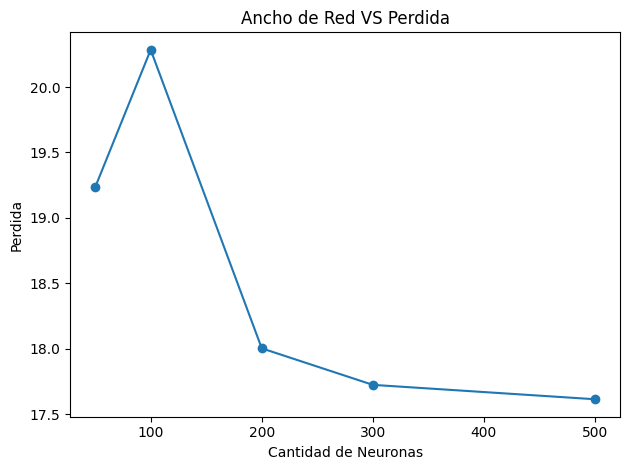

In [64]:
import pandas as pd
df1 = pd.DataFrame(performance_1)
plt.title("Ancho de Red VS Perdida")
plt.plot(df1["Ancho"], df1["t_loss"], '-o')
plt.xlabel("Cantidad de Neuronas")
plt.ylabel("Perdida")
plt.tight_layout()
plt.show()

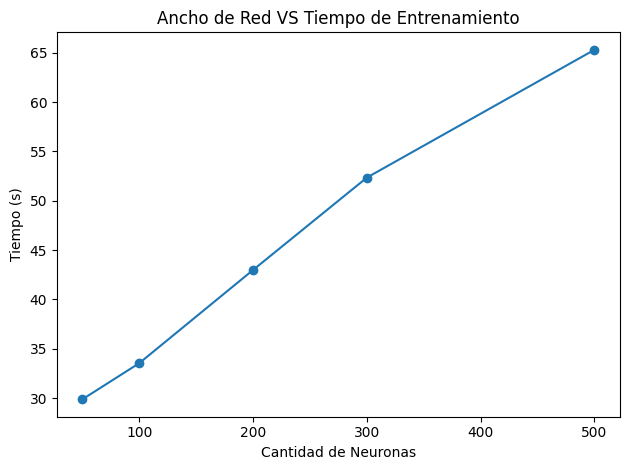

In [67]:
plt.title("Ancho de Red VS Tiempo de Entrenamiento")
plt.plot(df1["Ancho"], df1["training_time"], '-o')
plt.xlabel("Cantidad de Neuronas")
plt.ylabel("Tiempo (s)")
plt.tight_layout()
plt.show()

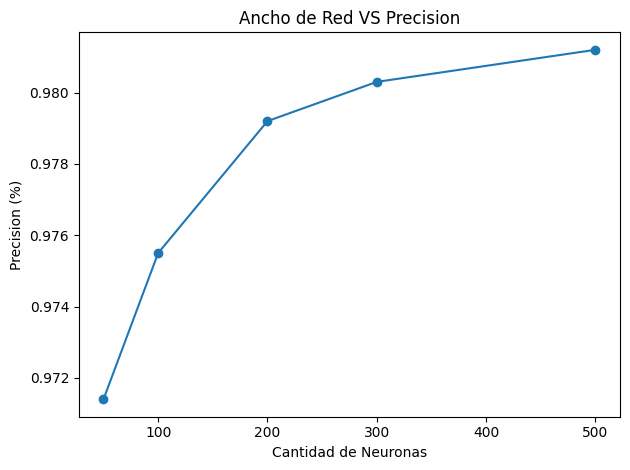

In [69]:
plt.title("Ancho de Red VS Precision")
plt.plot(df1["Ancho"], df1["t_acc"], '-o')
plt.xlabel("Cantidad de Neuronas")
plt.ylabel("Precision (%)")
plt.tight_layout()
plt.show()

In [70]:
df1

,Ancho,e_loss,e_acc,t_loss,t_acc,training_time
0,50,0.029982,0.99200,19.233328,0.9714,29.882279
1,100,0.008330,0.99860,20.284981,0.9755,33.547750
2,200,0.006966,0.99824,18.002359,0.9792,42.989387
3,300,0.009971,0.99674,17.723146,0.9803,52.345462
4,500,0.002838,0.99924,17.613148,0.9812,65.295912


## 2. Profundidad de Red

In [96]:
# Modelo con una capa interna
m2_one_layer = RNN(784, 10, 200)
m2_one_layer.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
            tf.keras.layers.Dense(200, activation='relu'), # 1a capa escondida
            tf.keras.layers.Dense(10, activation='softmax') # capa salida
        ])
m2_one_layer.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Modelo con 2 capas internas
m2_two_layer = RNN(784, 10, 200)
m2_two_layer.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
            tf.keras.layers.Dense(200, activation='relu'), # 1a capa escondida
            tf.keras.layers.Dense(200, activation='relu'), # 2a capa escondida
            tf.keras.layers.Dense(10, activation='softmax') # capa salida
        ])
m2_two_layer.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
for i, layer in enumerate(m2_one_layer.model.layers):
    weights = layer.get_weights() 
    print(f"Layer {i}: {layer.name}")
    for j, param in enumerate(weights):
        print(f"  Param {j} shape: {param.shape}")
m2_one_layer.model.summary()

Layer 0: flatten_54
Layer 1: dense_119
  Param 0 shape: (784, 200)
  Param 1 shape: (200,)
Layer 2: dense_120
  Param 0 shape: (200, 10)
  Param 1 shape: (10,)


Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_54 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 200)            │       157,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ (None, 10)             │         2,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,010 (621.13 KB)

 Trainable params: 159,010 (621.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
for i, layer in enumerate(m2_two_layer.model.layers):
    weights = layer.get_weights()
    print(f"Layer {i}: {layer.name}")
    for j, param in enumerate(weights):
        print(f"  Param {j} shape: {param.shape}")
m2_two_layer.model.summary()

Layer 0: flatten_60
Layer 1: dense_132
  Param 0 shape: (784, 200)
  Param 1 shape: (200,)
Layer 2: dense_133
  Param 0 shape: (200, 200)
  Param 1 shape: (200,)
Layer 3: dense_134
  Param 0 shape: (200, 10)
  Param 1 shape: (10,)


Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_60 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ (None, 200)            │       157,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 10)             │         2,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,210 (778.16 KB)

 Trainable params: 199,210 (778.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
500/500 - 4s - 7ms/step - accuracy: 0.9059 - loss: 0.3372 - val_accuracy: 0.9540 - val_loss: 0.1708
Epoch 2/20
500/500 - 3s - 5ms/step - accuracy: 0.9565 - loss: 0.1508 - val_accuracy: 0.9654 - val_loss: 0.1204
Epoch 3/20
500/500 - 3s - 5ms/step - accuracy: 0.9694 - loss: 0.1035 - val_accuracy: 0.9711 - val_loss: 0.1017
Epoch 4/20
500/500 - 3s - 5ms/step - accuracy: 0.9777 - loss: 0.0777 - val_accuracy: 0.9728 - val_loss: 0.0936
Epoch 5/20
500/500 - 3s - 5ms/step - accuracy: 0.9828 - loss: 0.0585 - val_accuracy: 0.9741 - val_loss: 0.0855
Epoch 6/20
500/500 - 3s - 6ms/step - accuracy: 0.9864 - loss: 0.0474 - val_accuracy: 0.9760 - val_loss: 0.0874
Epoch 7/20
500/500 - 3s - 5ms/step - accuracy: 0.9896 - loss: 0.0370 - val_accuracy: 0.9775 - val_loss: 0.0806
Epoch 8/20
500/500 - 2s - 5ms/step - accuracy: 0.9923 - loss: 0.0297 - val_accuracy: 0.9788 - val_loss: 0.0791
Epoch 9/20
500/500 - 2s - 5ms/step - accuracy: 0.9937 - loss: 0.0240 - val_accuracy: 0.9791 - val_loss: 0.0753
E

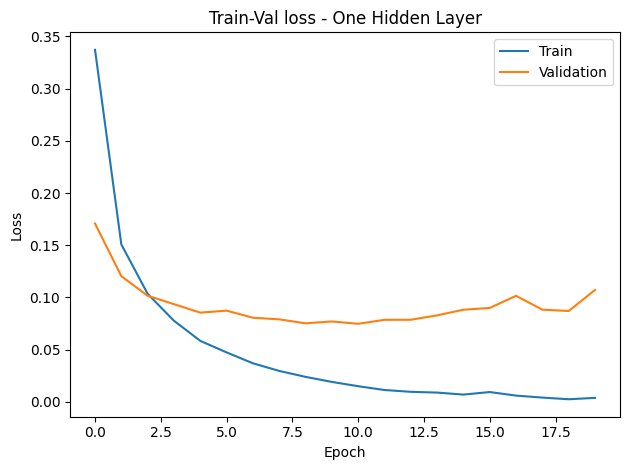

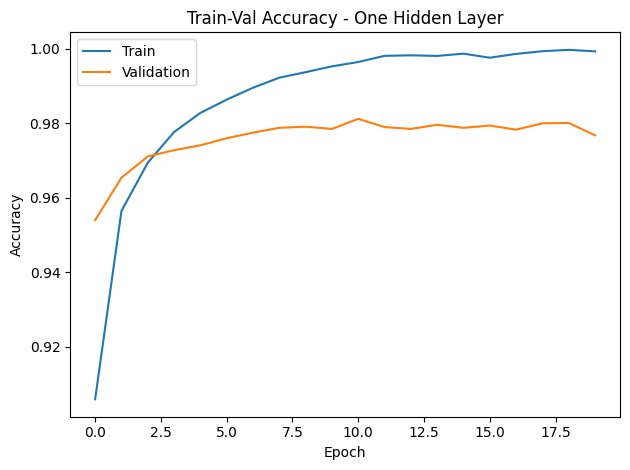

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9769 - loss: 20.9406  
Testing loss: 20.94064712524414, Testing Accuracy: 0.9768999814987183


In [98]:
# Entrenamiento 1a capa
(e_loss, e_acc, _, _, t_time) = m2_one_layer.train(datos_entreno, datos_validacion, num_epochs=20, verbose=2)
print(f"Training Time: {t_time}")
m2_one_layer.plot_loss("Train-Val loss - One Hidden Layer")
m2_one_layer.plot_accuracy("Train-Val Accuracy - One Hidden Layer")
t_loss, t_acc = m2_one_layer.test(datos_prueba)
print(f"Testing loss: {t_loss}, Testing Accuracy: {t_acc}")

Epoch 1/20
500/500 - 4s - 8ms/step - accuracy: 0.9179 - loss: 0.2800 - val_accuracy: 0.9601 - val_loss: 0.1342
Epoch 2/20
500/500 - 3s - 5ms/step - accuracy: 0.9671 - loss: 0.1072 - val_accuracy: 0.9699 - val_loss: 0.0998
Epoch 3/20
500/500 - 3s - 5ms/step - accuracy: 0.9792 - loss: 0.0673 - val_accuracy: 0.9737 - val_loss: 0.0877
Epoch 4/20
500/500 - 3s - 6ms/step - accuracy: 0.9836 - loss: 0.0526 - val_accuracy: 0.9775 - val_loss: 0.0773
Epoch 5/20
500/500 - 3s - 6ms/step - accuracy: 0.9880 - loss: 0.0383 - val_accuracy: 0.9771 - val_loss: 0.0739
Epoch 6/20
500/500 - 3s - 5ms/step - accuracy: 0.9900 - loss: 0.0302 - val_accuracy: 0.9758 - val_loss: 0.0823
Epoch 7/20
500/500 - 3s - 5ms/step - accuracy: 0.9922 - loss: 0.0233 - val_accuracy: 0.9770 - val_loss: 0.0838
Epoch 8/20
500/500 - 3s - 5ms/step - accuracy: 0.9938 - loss: 0.0196 - val_accuracy: 0.9791 - val_loss: 0.0792
Epoch 9/20
500/500 - 3s - 6ms/step - accuracy: 0.9946 - loss: 0.0165 - val_accuracy: 0.9771 - val_loss: 0.0960
E

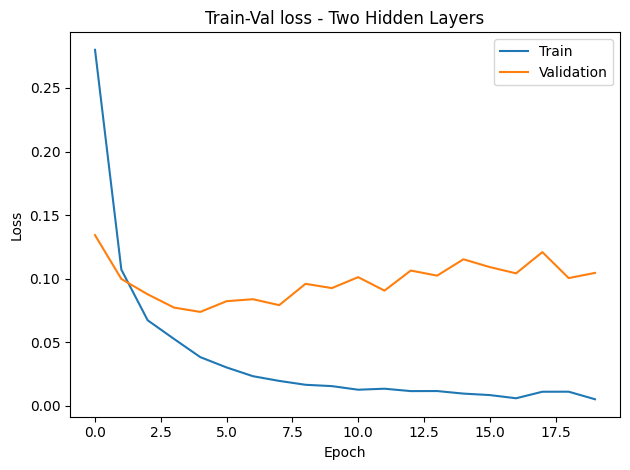

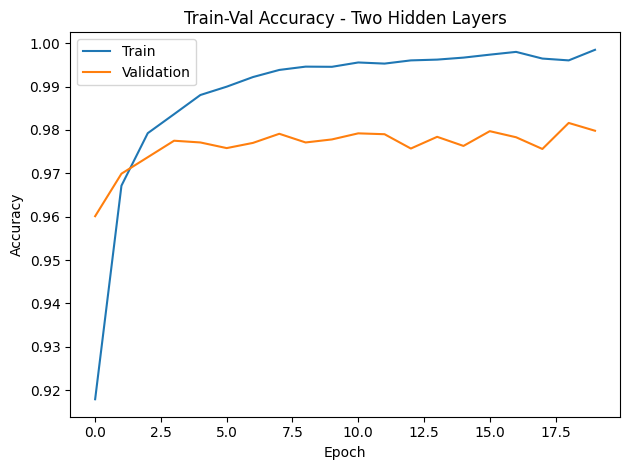

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9823 - loss: 22.0926
Testing loss: 22.09262466430664, Testing Accuracy: 0.9822999835014343


In [99]:
# Entrenamiento 2 capas
(e_loss, e_acc, _, _, t_time) = m2_two_layer.train(datos_entreno, datos_validacion, num_epochs=20, verbose=2)
print(f"Training Time: {t_time}")
m2_two_layer.plot_loss("Train-Val loss - Two Hidden Layers")
m2_two_layer.plot_accuracy("Train-Val Accuracy - Two Hidden Layers")
t_loss, t_acc = m2_two_layer.test(datos_prueba)
print(f"Testing loss: {t_loss}, Testing Accuracy: {t_acc}")

## 3. Redes profunas

Epoch 1/20


C:\Users\JM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


500/500 - 6s - 13ms/step - accuracy: 0.9150 - loss: 0.2853 - val_accuracy: 0.9612 - val_loss: 0.1345
Epoch 2/20
500/500 - 5s - 10ms/step - accuracy: 0.9681 - loss: 0.1050 - val_accuracy: 0.9735 - val_loss: 0.0881
Epoch 3/20
500/500 - 5s - 9ms/step - accuracy: 0.9784 - loss: 0.0683 - val_accuracy: 0.9712 - val_loss: 0.0998
Epoch 4/20
500/500 - 5s - 9ms/step - accuracy: 0.9836 - loss: 0.0538 - val_accuracy: 0.9736 - val_loss: 0.0928
Epoch 5/20
500/500 - 5s - 9ms/step - accuracy: 0.9869 - loss: 0.0421 - val_accuracy: 0.9762 - val_loss: 0.0883
Epoch 6/20
500/500 - 5s - 9ms/step - accuracy: 0.9890 - loss: 0.0344 - val_accuracy: 0.9765 - val_loss: 0.0815
Epoch 7/20
500/500 - 4s - 9ms/step - accuracy: 0.9916 - loss: 0.0261 - val_accuracy: 0.9786 - val_loss: 0.0912
Epoch 8/20
500/500 - 5s - 9ms/step - accuracy: 0.9914 - loss: 0.0287 - val_accuracy: 0.9779 - val_loss: 0.0851
Epoch 9/20
500/500 - 5s - 10ms/step - accuracy: 0.9932 - loss: 0.0212 - val_accuracy: 0.9753 - val_loss: 0.0960
Epoch 10/

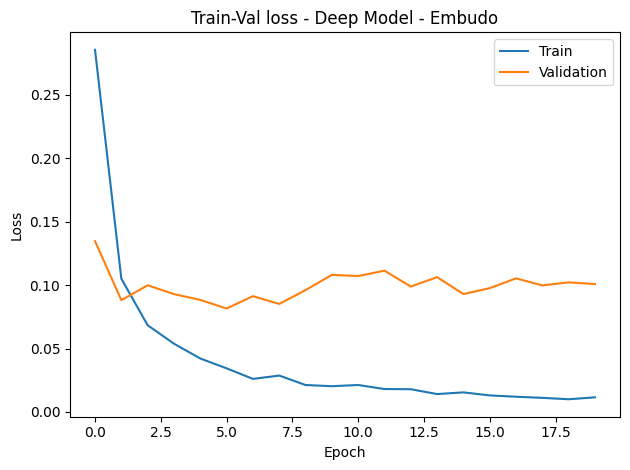

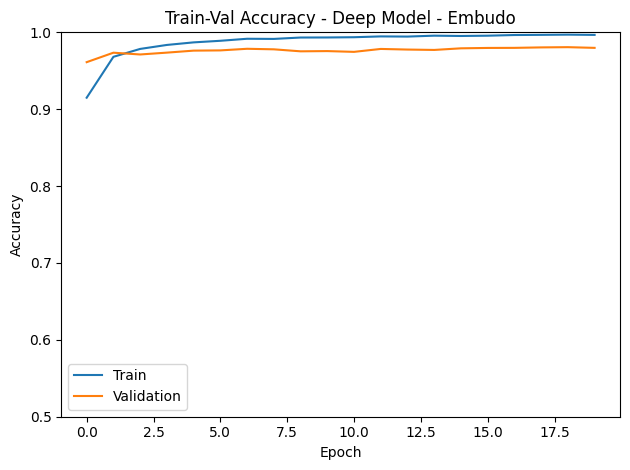

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9811 - loss: 20.8283
Testing loss: 20.828269958496094, Testing Accuracy: 0.9811000227928162


In [16]:
# Init
m3_a = RNN(784, 10, 200)
m3_a.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax') # capa salida
        ])
m3_a.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
(e_loss, e_acc, _, _, t_time) = m3_a.train(datos_entreno, datos_validacion, num_epochs=20, verbose=2)
print(f"Training Time: {t_time}")
m3_a.plot_loss("Train-Val loss - Deep Model - Embudo")
m3_a.plot_accuracy("Train-Val Accuracy - Deep Model - Embudo")

# Test
t_loss, t_acc = m3_a.test(datos_prueba)
print(f"Testing loss: {t_loss}, Testing Accuracy: {t_acc}")

Epoch 1/20
500/500 - 5s - 11ms/step - accuracy: 0.9171 - loss: 0.2674 - val_accuracy: 0.9596 - val_loss: 0.1332
Epoch 2/20
500/500 - 4s - 8ms/step - accuracy: 0.9670 - loss: 0.1072 - val_accuracy: 0.9683 - val_loss: 0.1083
Epoch 3/20
500/500 - 4s - 8ms/step - accuracy: 0.9770 - loss: 0.0749 - val_accuracy: 0.9745 - val_loss: 0.0885
Epoch 4/20
500/500 - 4s - 8ms/step - accuracy: 0.9822 - loss: 0.0571 - val_accuracy: 0.9749 - val_loss: 0.0905
Epoch 5/20
500/500 - 4s - 8ms/step - accuracy: 0.9848 - loss: 0.0469 - val_accuracy: 0.9773 - val_loss: 0.0778
Epoch 6/20
500/500 - 4s - 8ms/step - accuracy: 0.9868 - loss: 0.0425 - val_accuracy: 0.9751 - val_loss: 0.0909
Epoch 7/20
500/500 - 4s - 8ms/step - accuracy: 0.9901 - loss: 0.0336 - val_accuracy: 0.9775 - val_loss: 0.0925
Epoch 8/20
500/500 - 4s - 8ms/step - accuracy: 0.9916 - loss: 0.0282 - val_accuracy: 0.9725 - val_loss: 0.1134
Epoch 9/20
500/500 - 4s - 8ms/step - accuracy: 0.9913 - loss: 0.0282 - val_accuracy: 0.9746 - val_loss: 0.1144


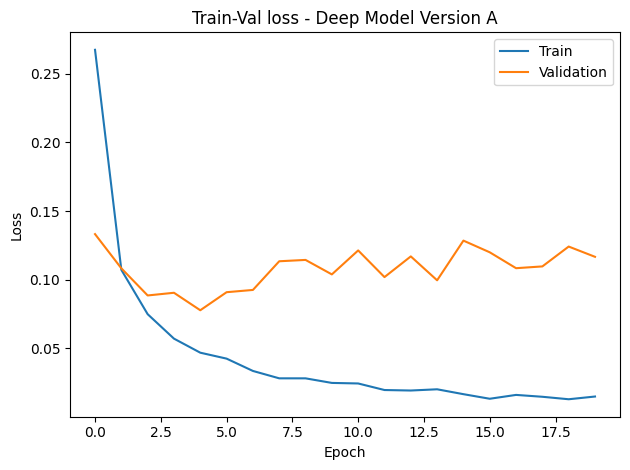

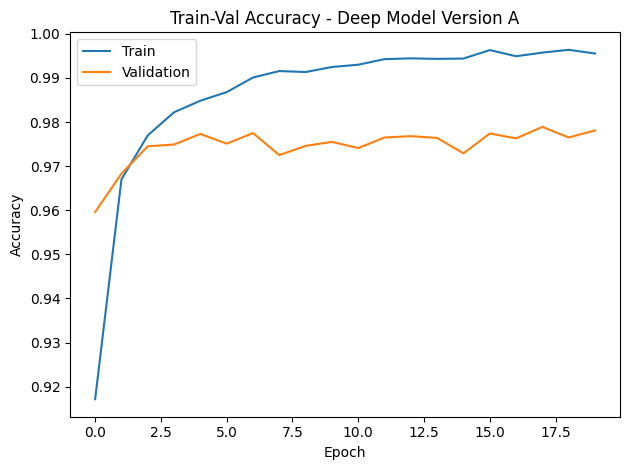

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9790 - loss: 20.9569
Testing loss: 20.956932067871094, Testing Accuracy: 0.9789999723434448


In [104]:
# Init
m3_b = RNN(784, 10, 200)
m3_b.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax') # capa salida
        ])
m3_b.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
(e_loss, e_acc, _, _, t_time) = m3_b.train(datos_entreno, datos_validacion, num_epochs=20, verbose=2)
print(f"Training Time: {t_time}")
m3_b.plot_loss("Train-Val loss - Deep Model Version A")
m3_b.plot_accuracy("Train-Val Accuracy - Deep Model Version A")

# Test
t_loss, t_acc = m3_b.test(datos_prueba)
print(f"Testing loss: {t_loss}, Testing Accuracy: {t_acc}")

Epoch 1/20


C:\Users\JM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


500/500 - 6s - 12ms/step - accuracy: 0.9149 - loss: 0.2844 - val_accuracy: 0.9597 - val_loss: 0.1331
Epoch 2/20
500/500 - 4s - 8ms/step - accuracy: 0.9662 - loss: 0.1089 - val_accuracy: 0.9701 - val_loss: 0.0970
Epoch 3/20
500/500 - 3s - 7ms/step - accuracy: 0.9769 - loss: 0.0755 - val_accuracy: 0.9746 - val_loss: 0.0848
Epoch 4/20
500/500 - 4s - 7ms/step - accuracy: 0.9814 - loss: 0.0589 - val_accuracy: 0.9757 - val_loss: 0.0849
Epoch 5/20
500/500 - 4s - 8ms/step - accuracy: 0.9856 - loss: 0.0479 - val_accuracy: 0.9766 - val_loss: 0.0861
Epoch 6/20
500/500 - 6s - 11ms/step - accuracy: 0.9872 - loss: 0.0402 - val_accuracy: 0.9742 - val_loss: 0.0942
Epoch 7/20
500/500 - 4s - 8ms/step - accuracy: 0.9898 - loss: 0.0336 - val_accuracy: 0.9745 - val_loss: 0.1100
Epoch 8/20
500/500 - 4s - 8ms/step - accuracy: 0.9912 - loss: 0.0279 - val_accuracy: 0.9792 - val_loss: 0.0805
Epoch 9/20
500/500 - 3s - 7ms/step - accuracy: 0.9918 - loss: 0.0270 - val_accuracy: 0.9778 - val_loss: 0.0920
Epoch 10/2

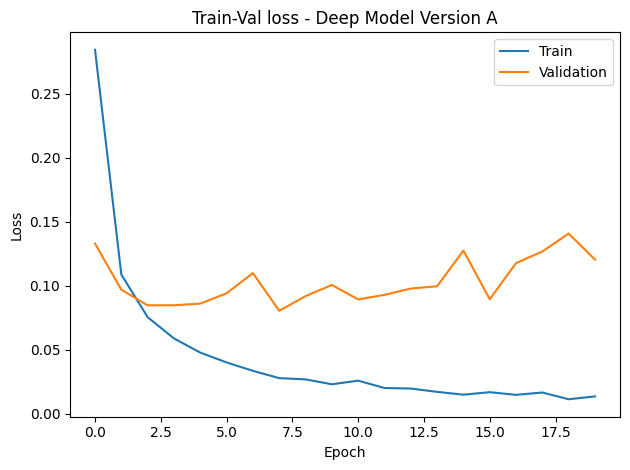

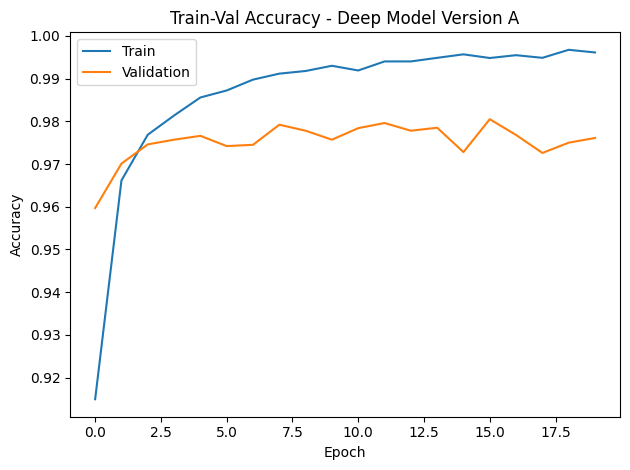

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9738 - loss: 26.4671
Testing loss: 26.467124938964844, Testing Accuracy: 0.973800003528595


In [105]:
# kida random
# Init
m3_c = RNN(784, 10, 200)
m3_c.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax') # capa salida
        ])
m3_c.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
(e_loss, e_acc, _, _, t_time) = m3_c.train(datos_entreno, datos_validacion, num_epochs=20, verbose=2)
print(f"Training Time: {t_time}")
m3_c.plot_loss("Train-Val loss - Deep Model Version A")
m3_c.plot_accuracy("Train-Val Accuracy - Deep Model Version A")

# Test
t_loss, t_acc = m3_c.test(datos_prueba)
print(f"Testing loss: {t_loss}, Testing Accuracy: {t_acc}")

### 4. Funciones de Activacion 1

Epoch 1/20
500/500 - 6s - 12ms/step - accuracy: 0.6886 - loss: 0.9068 - val_accuracy: 0.8992 - val_loss: 0.3563
Epoch 2/20
500/500 - 5s - 10ms/step - accuracy: 0.9137 - loss: 0.3042 - val_accuracy: 0.9455 - val_loss: 0.1927
Epoch 3/20
500/500 - 5s - 10ms/step - accuracy: 0.9456 - loss: 0.1910 - val_accuracy: 0.9537 - val_loss: 0.1695
Epoch 4/20
500/500 - 5s - 10ms/step - accuracy: 0.9561 - loss: 0.1486 - val_accuracy: 0.9605 - val_loss: 0.1343
Epoch 5/20
500/500 - 5s - 9ms/step - accuracy: 0.9664 - loss: 0.1170 - val_accuracy: 0.9663 - val_loss: 0.1161
Epoch 6/20
500/500 - 4s - 9ms/step - accuracy: 0.9727 - loss: 0.0974 - val_accuracy: 0.9681 - val_loss: 0.1144
Epoch 7/20
500/500 - 5s - 10ms/step - accuracy: 0.9749 - loss: 0.0861 - val_accuracy: 0.9675 - val_loss: 0.1099
Epoch 8/20
500/500 - 5s - 9ms/step - accuracy: 0.9793 - loss: 0.0701 - val_accuracy: 0.9702 - val_loss: 0.1059
Epoch 9/20
500/500 - 5s - 10ms/step - accuracy: 0.9810 - loss: 0.0637 - val_accuracy: 0.9693 - val_loss: 0.

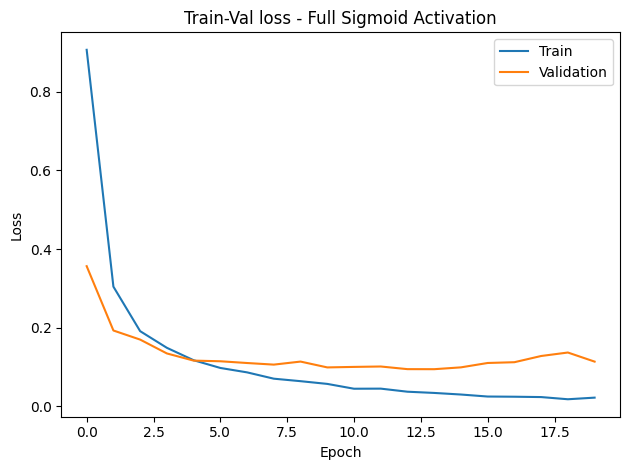

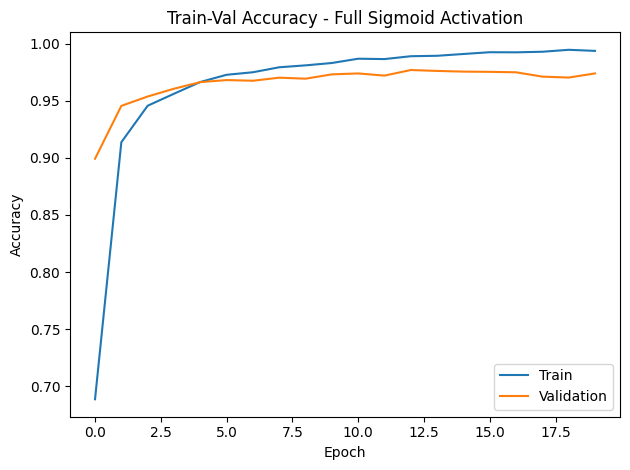

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9694 - loss: 0.1411
Testing loss: 0.14105820655822754, Testing Accuracy: 0.9693999886512756


In [18]:
# Init
m4 = RNN(784, 10, 200)
m4.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
            tf.keras.layers.Dense(256, activation='sigmoid'),
            tf.keras.layers.Dense(256, activation='sigmoid'),
            tf.keras.layers.Dense(256, activation='sigmoid'),
            tf.keras.layers.Dense(256, activation='sigmoid'),
            tf.keras.layers.Dense(256, activation='sigmoid'),
            tf.keras.layers.Dense(10, activation='softmax') # capa salida
        ])
m4.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
(e_loss, e_acc, _, _, t_time) = m4.train(datos_entreno, datos_validacion, num_epochs=20, verbose=2)
print(f"Training Time: {t_time}")
m4.plot_loss("Train-Val loss - Full Sigmoid Activation")
m4.plot_accuracy("Train-Val Accuracy - Full Sigmoid Activation")

# Test
t_loss, t_acc = m4.test(datos_prueba)
print(f"Testing loss: {t_loss}, Testing Accuracy: {t_acc}")

### 5. Funciones de Activacion 2

Epoch 1/20
500/500 - 4s - 8ms/step - accuracy: 0.9235 - loss: 0.2564 - val_accuracy: 0.9640 - val_loss: 0.1206
Epoch 2/20
500/500 - 3s - 6ms/step - accuracy: 0.9696 - loss: 0.0958 - val_accuracy: 0.9721 - val_loss: 0.0921
Epoch 3/20
500/500 - 3s - 6ms/step - accuracy: 0.9809 - loss: 0.0603 - val_accuracy: 0.9750 - val_loss: 0.0882
Epoch 4/20
500/500 - 3s - 6ms/step - accuracy: 0.9872 - loss: 0.0406 - val_accuracy: 0.9767 - val_loss: 0.0853
Epoch 5/20
500/500 - 3s - 6ms/step - accuracy: 0.9896 - loss: 0.0310 - val_accuracy: 0.9730 - val_loss: 0.0935
Epoch 6/20
500/500 - 3s - 6ms/step - accuracy: 0.9919 - loss: 0.0251 - val_accuracy: 0.9780 - val_loss: 0.0809
Epoch 7/20
500/500 - 3s - 6ms/step - accuracy: 0.9941 - loss: 0.0183 - val_accuracy: 0.9771 - val_loss: 0.0901
Epoch 8/20
500/500 - 3s - 6ms/step - accuracy: 0.9944 - loss: 0.0162 - val_accuracy: 0.9809 - val_loss: 0.0849
Epoch 9/20
500/500 - 3s - 6ms/step - accuracy: 0.9950 - loss: 0.0137 - val_accuracy: 0.9783 - val_loss: 0.0869
E

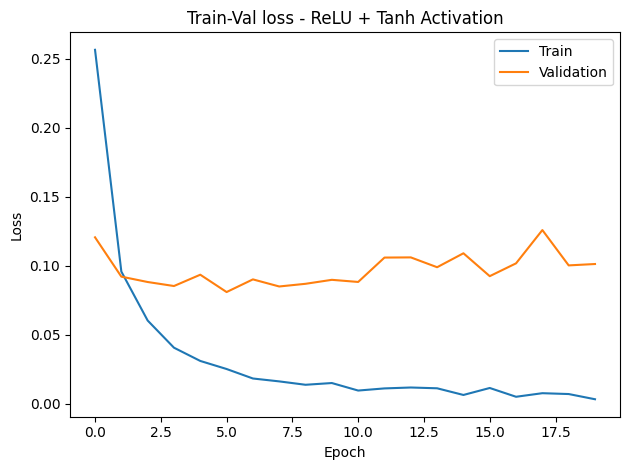

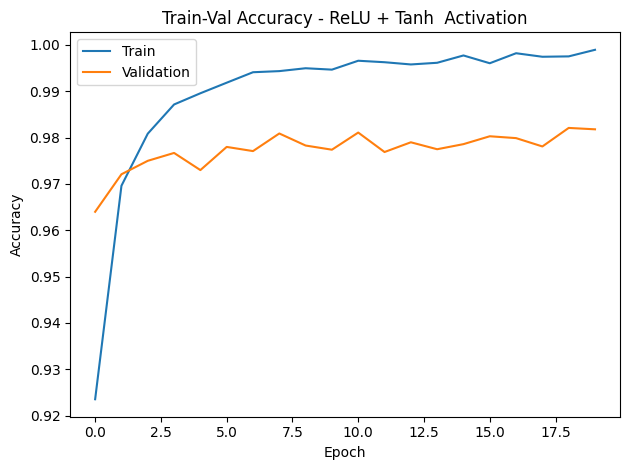

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9793 - loss: 0.1205
Testing loss: 0.12052429467439651, Testing Accuracy: 0.9793000221252441


In [20]:
# Init
m5 = RNN(784, 10, 200)
m5.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(256, activation='tanh'),
            tf.keras.layers.Dense(10, activation='softmax') # capa salida
        ])
m5.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
(e_loss, e_acc, _, _, t_time) = m5.train(datos_entreno, datos_validacion, num_epochs=20, verbose=2)
print(f"Training Time: {t_time}")
m5.plot_loss("Train-Val loss - ReLU + Tanh Activation")
m5.plot_accuracy("Train-Val Accuracy - ReLU + Tanh  Activation")

# Test
t_loss, t_acc = m5.test(datos_prueba)
print(f"Testing loss: {t_loss}, Testing Accuracy: {t_acc}")

### 6. Tamaño Batch Grande